Trees and diversity estimates for molecular markers. Env from 62_phylo_reduced.

After first run and evaluation, manually resolve problems with selected sequences (on plate fasta level):
- VBS00055 (aconitus) its2 trimmed 3' - weak signal, multipeaks
- VBS00021,VBS00022,VBS00023 (barbirostris) its2 re-trimmed to the same length - sequences too long, weak signal after 1000 bases
- VBS00024 (barbirostris) its2 removed - weak signal, multipeaks
- marshalli mis-identifications - remove all samples from analysis
- VBS00059, VBS00061 (minimus) coi trimmed 5' - retained variation is true
- VBS00145 (sundaicus) is rampae according to its2 and ampseq - removed from analysis
- vin.M0004, vin.B0009, vin.M0009 its2 removed - problem with amplification after ca 60 bases

After finalisation of sequences, need to re-run BLAST and 1_blast.ipynb

Higher than expexted variation left without changes:
- carnevalei its2 - legitimately highly variable
- coustani, tenebrosus, ziemannii - highly variable unresolved group with two branches according to all markers
- hyrcanus - two distinct lineages - VBS00082, VBS00083 and VBS00085,VBS00086 according to all markers
- nili - two distinct lineages - nil.237, nil.239 and nil.233, nil.236, nil.238 according to all markers 
- paludis: Apal-81 within coustani group, while Apal-257 is an outgroup according to all markers
- VBS00113 (rampae) coi groups with maculatus (closest relative), while its2 and ampseq group it with rampae
- sundaicus coi - legitimately highly variable
- theileri its - multipeaks at the middle of all samples result in several bases mis-called, do not change 
- vagus coi - legitimately highly variable

Other:
- brohieri, hancocki, demeilloni - single group of closely related individuals according to all markers

In [1]:
import os
from Bio import AlignIO, SeqIO
from Bio.Phylo.TreeConstruction import DistanceCalculator
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ete3

In [2]:
# in
WD = '../../../data/phylo_ampl_dada2/coi_its2/work/'
PRD = '../../../data/phylo_ampl_dada2/phylo_reduced'
OD = 'data'
META = os.path.join(OD, 'species_predictions.csv')
FA = os.path.join(WD, 'seqman_fa/plate{}.fas')
AMPL_ALN = os.path.join(PRD,'aln_all/{}.fa')
AMPL_HAP = os.path.join(PRD,'0_haplotypes.csv')
TAXONOMY = '../7_species_id/data/0_taxonomy.csv'
# out
ALN = os.path.join(WD, 'phylo/{}.aln.fas')
TREE = os.path.join(OD, '{}.nwk')
TREE_FIG = os.path.join(OD, '{}.pdf')
TREE_FIG_UNFILTERED = os.path.join(WD, 'phylo/{}.all.pdf')
DIVERSITY = os.path.join(OD, 'diversity.csv')

In [3]:
! mkdir -p {os.path.join(WD, 'phylo')}
! mkdir -p {OD}

In [34]:
# mapping of markers used and plates
MARKER_PLATES = {
    'coi':[1,2],
    'its2':[3,4]
}
# samples with conflicting phylogenetic positions - to be removed from diversity estimates
CONFLICT_SAMPLES = ['Amar-3-1','Amar-42','Amar-5','VBS00145']
# minimum number of samples per species to be used in diversity plotting
MIN_SAMPLES_DIV = 2
# species labels containing multiple - hard filtering
MULTISP_LABELS = ['brohieri', 'hancocki', 'demeilloni', 
                  'coustani','tenebrosus','ziemanni',
                  'hyrcanus','nili','paludis']
# species that are overly diverged - softer filtering
BAD_SPP = ['hyrcanus','nili','paludis']
MULTISP_LABELS = ['Anopheles_'+l for l in MULTISP_LABELS]
BAD_SPP = ['Anopheles_'+l for l in BAD_SPP]

## Metadata 

In [5]:
meta = pd.read_csv(META, index_col=0)
meta.shape

(144, 44)

In [6]:
# metadata table for use in diversity estimates - only include ampseq'd and non-conflicting samples
# remove non-ampseq'd
ampseq_meta = meta[~meta.ampseq_species.isna()]
# remove conflicting samples 
# ampseq_meta = ampseq_meta[~ampseq_meta.index.isin(CONFLICT_SAMPLES)]
display(ampseq_meta.shape)
ampseq_meta.head(1)

(123, 44)

,partner_species,amplicons_recovered,ampseq_species,bold_best_id,bold_top_%,bold_low_%,COI_length,COI_num_alignments,COI_species_predictions,COI_top10_species,...,ITS2_first_hit_score,ITS2_second_hit,ITS2_second_hit_species,ITS2_second_hit_hsps,ITS2_second_hit_length,ITS2_second_hit_identities,ITS2_second_hit_identity,ITS2_second_hit_score,COI_seqid,ITS2_seqid
Abro-21,Anopheles_brohieri,21.0,"Anopheles_brohieri, Anopheles_demeilloni, Anop...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,355.0,gi|374676298|gb|JN994151.1|,Anopheles_theileri,1.0,481.0,438.0,91.060291,344.0,NaN,bro.21_A10-ITS2A.ab1


In [7]:
# basic stats
meta[~meta.ampseq_species.isna()].COI_length.mean(), meta[~meta.ampseq_species.isna()].COI_length.std()

(584.2857142857143, 87.54966966782146)

## Alignment and phylogeny

In [8]:
for marker, plates in MARKER_PLATES.items():
    ! cat {FA.format(plates[0])} {FA.format(plates[1])} | mafft - > {ALN.format(marker)}

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 3 ambiguous characters.
  101 / 127
done.

Constructing a UPGMA tree (efffree=0) ... 
  120 / 127
done.

Progressive alignment 1/2... 
STEP   126 / 126 
done.

Making a distance matrix from msa.. 
  100 / 127
done.

Constructing a UPGMA tree (efffree=1) ... 
  120 / 127
done.

Progressive alignment 2/2... 
STEP   126 / 126  h
done.

disttbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert mo

In [9]:
for marker in MARKER_PLATES:
    ! fasttree -nt {ALN.format(marker)} > {TREE.format(marker)}

FastTree Version 2.1.10 Double precision (No SSE3)
Alignment: ../../../data/phylo_ampl_dada2/coi_its2/work/phylo/coi.aln.fas
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jukes-Cantor, CAT approximation with 20 rate categories
Ignored unknown character n (seen 2 times)
Ignored unknown character w (seen 1 times)
Initial topology in 0.03 seconds
Refining topology: 27 rounds ME-NNIs, 2 rounds ME-SPRs, 13 rounds ML-NNIs
Total branch-length 1.828 after 0.33 sec, 101 of 200 nodes   
ML-NNI round 1: LogLk = -7673.123 NNIs 21 max delta 9.36 Time 0.50
Switched to using 20 rate categories (CAT approximation)1 of 20   
Rate categories were divided by 0.851 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -6618.283 NNIs 8 ma

In [10]:
# draw trees
for marker in MARKER_PLATES:
    t = ete3.Tree(TREE.format(marker))
    # set outgroup to implexus 
    outgroups = []
    for leaf in t:
        if leaf.name.startswith('imp'):# or leaf.name.startswith('cou'):
            outgroups.append(leaf.name)            
#     print(outgroups)
    if len(outgroups) > 1:
        t.set_outgroup(t.get_common_ancestor(*outgroups))
    elif len(outgroups) == 1:
        t.set_outgroup(outgroups[0])
    
    # style
    t.ladderize(direction=1)
    ns = ete3.NodeStyle(size=0)
    for n in t.traverse():
        n.set_style(ns)
        
    t.render(TREE_FIG_UNFILTERED.format(marker)); 
    
    # remove non-ampseq samples from tree
    pruned_taxa = [leaf.name for leaf in t if leaf.name in ampseq_meta[marker.upper() + '_seqid'].to_list()]
    print(pruned_taxa)
    t.prune(pruned_taxa)
            
    t.render(TREE_FIG.format(marker)); 

['zie.1032_A04-HCO2198.ab1', 'zie.70_C04-HCO2198.ab1', 'ten.79_F04-HCO2198.ab1', 'pal.81_C09-HCO2198.ab1', 'ten.333_A05-HCO2198.ab1', 'zie.1055_E04-HCO2198.ab1', 'zie.77_D04-HCO2198.ab1', 'ten.954_B05-HCO2198.ab1', 'cou.80_A03-HCO2198.ab1', 'cou.71_H02-HCO2198.ab1', 'zie.334_B04-HCO2198.ab1', 'cou.962_C03-HCO2198.ab1', 'cou.959_D03-HCO2198.ab1', 'ten.185_G04-HCO2198.ab1', 'cou.956_B03-HCO2198.ab1', 'ten.191_H04-HCO2198.ab1', 'pal.10_B09-HCO2198.ab1', 'pal.4_A09-HCO2198.ab1', 'pal.257_D09-HCO2198.ab1', 'VBS00084_D03-HCO2198.ab1', 'VBS00083_C03-HCO2198.ab1', 'VBS00082_B03-HCO2198.ab1', 'VBS00086_F03-HCO2198.ab1', 'VBS00085_E03-HCO2198.ab1', 'nils.7_H12-HCO2198.ab1', 'nil.239_B02-HCO2198.ab1', 'nil.237_H01-HCO2198.ab1', 'nil.236_G01-HCO2198.ab1', 'nil.233_F01-HCO2198.ab1', 'nil.238_A02-HCO2198.ab1', 'car.191_A01-HCO2198.ab1', 'car.192_D02-HCO2198.ab1', 'car.195_A06-HCO2198.ab1', 'car.193_E02-HCO2198.ab1', 'car.194_B05-HCO2198.ab1', 'VBS00025_A02-HCO2198.ab1', 'VBS00023_G01-HCO2198.ab1', '

In [11]:
'col.554_D08-ITS2A.ab1' in ampseq_meta.COI_seqid.to_list()

False

## Diversity estimates for Sanger sequencing

In [12]:
# variable sites
def distances(aln, seqids):
    s_aln = [seq for seq in aln if seq.name in seqids]
    s_aln = AlignIO.MultipleSeqAlignment(s_aln)
    aln_len = len(s_aln[0].seq)
    dist_matrix = DistanceCalculator('identity').get_distance(s_aln)
    dists = []
    for i, d in enumerate(dist_matrix):
        dists.extend(d[:i])
    dists = [int(d * aln_len) for d in dists]
    return dists

def aln_stats(aln, seqids, verbose=False):
    
    var_sites = 0
    aln_len = 0
    if len(seqids) == 0:
        return var_sites, aln_len
    # subset alignment to seqids
    s_aln = [seq for seq in aln if seq.name in seqids]
    s_aln = AlignIO.MultipleSeqAlignment(s_aln)
    # iterate over alignment columns
    for i in range(len(s_aln[0].seq)):
        chars = s_aln[:,i]
        charset = set(chars)
        # any aligned bases
        if charset != set('-'):
            aln_len += 1
        # any variable bases
        if len(charset - set('-')) > 1:
            if verbose:
                print(i, chars)
            var_sites += 1
            
    return var_sites, aln_len

aln_div = defaultdict(dict)
for marker in MARKER_PLATES:
    marker_aln = AlignIO.read(ALN.format(marker), format='fasta')
    marker_aln = list(marker_aln)

    for species, sp_meta in ampseq_meta.groupby('partner_species'):
        # remove conflicting samples
        sp_meta = sp_meta[~sp_meta.index.isin(CONFLICT_SAMPLES)]
        # subset samples
        sp_marker_samples = sp_meta[marker.upper()+'_seqid'].dropna().to_list()
        # debug
        if species == 'Anopheles_marshallii' and marker=='its2':
            print(sp_marker_samples)
            print(aln_stats(marker_aln, sp_marker_samples, verbose=True))
        # skip small datasets
        #if len(sp_marker_samples) < MIN_SAMPLES_DIV:
        #    continue
        v, l = aln_stats(marker_aln, sp_marker_samples)
        aln_div[marker + '_len'][species] = l
        aln_div[marker + '_var'][species] = v
        aln_div[marker + '_nseq'][species] = len(sp_marker_samples)
        #aln_div[marker + '_samples'][species] = sp_marker_samples
        #aln_div[marker + '_dists'][species] = distances(marker_aln, sp_marker_samples)


[]
(0, 0)


In [13]:
aln_div = pd.DataFrame(aln_div)
aln_div.head()

,coi_len,coi_var,coi_nseq,its2_len,its2_var,its2_nseq
Anopheles_aconitus,619,1,2,475,1,2
Anopheles_annularis,619,6,3,430,2,4
Anopheles_balabacensis,619,0,1,458,0,1
Anopheles_barbirostris,619,10,4,1024,3,3
Anopheles_brohieri,616,1,3,470,0,4


## Diversity estimates for ampseq

Use alignments generated for 62_phylo_reduced

In [14]:
ampl_haps = pd.read_csv(AMPL_HAP)
ampl_haps.head(1)

,c_Consensus,s_Sample,s_Species,source_id,target,combUID
0,TCTCCATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATG...,Abro-21,Anopheles_brohieri,run1,13,13-0


In [15]:
ampseq_var = defaultdict(dict)
ampseq_len = defaultdict(dict)
ampseq_nseq = dict()

for species, sp_meta in ampseq_meta.groupby('partner_species'):
    # remove conflicting samples
    sp_meta = sp_meta[~sp_meta.index.isin(CONFLICT_SAMPLES)]
    # subset samples
    sp_marker_samples = sp_meta.index.dropna().to_list()
    # skip small datasets
    #if len(sp_marker_aln) < MIN_SAMPLES_DIV:
    #    continue
    ampseq_nseq[species] = len(sp_marker_samples)
    for target in range(62):
        target = str(target)
        st_uids = ampl_haps.loc[ampl_haps.s_Sample.isin(sp_marker_samples) 
                                    & (ampl_haps.target == target),
                                'combUID'].to_list()
        # no sequences - no divergent sites
        if len(st_uids) == 0:
            ampseq_var[target][species] = np.nan
        # estimate divergent sites
        else:
            taln = AlignIO.read(AMPL_ALN.format(target), format='fasta')
            ampseq_var[target][species], ampseq_len[target][species] = aln_stats(taln, st_uids)

In [16]:
ampseq_var = pd.DataFrame(ampseq_var)
ampseq_len = pd.DataFrame(ampseq_len)
ampseq_len.iloc[:3,:3]

,0,1,3
Anopheles_aconitus,131.0,153.0,140
Anopheles_annularis,138.0,153.0,153
Anopheles_balabacensis,NaN,NaN,171


In [17]:
comb_div = aln_div.copy()
comb_div['total_ampseq_len'] = ampseq_len.sum(axis=1).astype(int)
comb_div['total_ampseq_var'] = ampseq_var.sum(axis=1).astype(int)
comb_div['total_ampseq_nsamples'] = pd.Series(ampseq_nseq)

In [18]:
comb_div

,coi_len,coi_var,coi_nseq,its2_len,its2_var,its2_nseq,total_ampseq_len,total_ampseq_var,total_ampseq_nsamples
Anopheles_aconitus,619,1,2,475,1,2,7712.0,45,2
Anopheles_annularis,619,6,3,430,2,4,9068.0,245,4
Anopheles_balabacensis,619,0,1,458,0,1,8047.0,28,1
Anopheles_barbirostris,619,10,4,1024,3,3,8054.0,255,5
Anopheles_brohieri,616,1,3,470,0,4,9739.0,62,4
Anopheles_carnevalei,620,5,5,480,18,5,8773.0,203,5
Anopheles_coluzzii,616,8,3,526,8,3,9336.0,278,3
Anopheles_coustani,616,11,5,586,52,5,8716.0,335,5
Anopheles_demeilloni,616,1,2,469,1,3,9286.0,55,3
Anopheles_dirus_A,619,1,2,813,3,3,8218.0,100,3


In [19]:
comb_div.to_csv(DIVERSITY)

## Plot diversity

In [20]:
taxonomy = pd.read_csv(TAXONOMY, index_col=0)
taxonomy.head(1)

,subgenus,section,series,group,subgroup,complex,species_ncbi
species,,,,,,,
Anopheles_aconitus,Cellia,NaN,Myzomyia,Minimus,NaN,NaN,Anopheles aconitus


In [21]:
comb_div['series'] = taxonomy['series']
comb_div['subgenus'] = taxonomy['subgenus']
def region(species):
    sp_data = ampseq_meta[ampseq_meta.partner_species == species]
    if sp_data.index[0].startswith('VBS'):
        return 'SE Asia'
    elif sp_data.index[0].startswith('A'):
        return 'Africa'
    return 'Unknown'
comb_div['region'] = comb_div.index.map(region)

Index(['Anopheles_minimus_A', 'Anopheles_rampae', 'Anopheles_sundaicus',
       'Anopheles_vagus'],
      dtype='object')
Index(['Anopheles_carnevalei', 'Anopheles_coustani', 'Anopheles_tenebrosus',
       'Anopheles_theileri', 'Anopheles_ziemanni'],
      dtype='object')


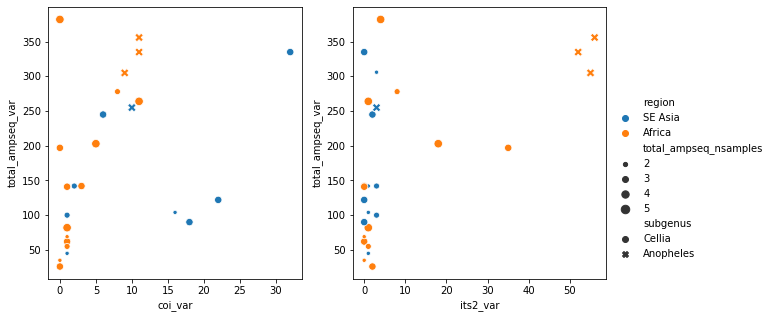

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
for ax, marker in zip(axs, ('coi','its2')):
    # exclude compromised species labels and species with insufficient sample size
    d = comb_div[~comb_div.index.isin(BAD_SPP) & # harder filter -  MULTISP_LABELS
                 (comb_div.total_ampseq_nsamples >= MIN_SAMPLES_DIV) &
                 (comb_div[marker+'_nseq'] >= MIN_SAMPLES_DIV)]
    print(d[d[marker+'_var'] > 12].index)
    sns.scatterplot(x=marker+'_var',y='total_ampseq_var',
                    hue='region',
                    size='total_ampseq_nsamples',
                    style='subgenus',
                    data=d,
                    ax=ax)
    ax.legend().set_visible(False)
ax.legend(bbox_to_anchor=(1, 0.7), frameon=False);

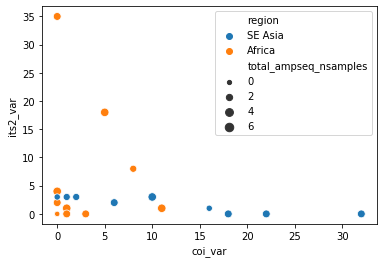

In [36]:
sns.scatterplot(data=comb_div[~comb_div.index.isin(MULTISP_LABELS)],
                x='coi_var',y='its2_var',hue='region',size='total_ampseq_nsamples');

In [37]:
# stats for good species (not multiple species with same label)
comb_div[~comb_div.index.isin(BAD_SPP) & 
         (comb_div.total_ampseq_nsamples >= MIN_SAMPLES_DIV)] \
    .describe()

,coi_len,coi_var,coi_nseq,its2_len,its2_var,its2_nseq,total_ampseq_len,total_ampseq_var,total_ampseq_nsamples
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,601.666667,6.370370,3.333333,536.888889,9.259259,3.370370,8943.111111,178.444444,3.703704
std,51.456479,8.043861,1.208941,143.064088,17.790647,1.148516,664.986370,111.377160,1.137298
min,402.000000,0.000000,1.000000,385.000000,0.000000,2.000000,7196.000000,26.000000,2.000000
25%,616.000000,1.000000,2.000000,468.000000,0.000000,2.000000,8639.500000,86.000000,3.000000
50%,616.000000,2.000000,4.000000,491.000000,1.000000,3.000000,9104.000000,142.000000,4.000000
75%,619.000000,10.500000,4.000000,573.000000,3.500000,4.000000,9390.500000,271.000000,5.000000
max,620.000000,32.000000,5.000000,1024.000000,56.000000,5.000000,9739.000000,382.000000,5.000000
